In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Maybe first good to see how well this configuration would extract a stationary atmosphere drawn from a Kolmogorov spectrum

# Some SPT Details
Data: In 100 seconds, SPT scans 100 degrees spits out ~$10^4$ data points per detector in ~tens of thousands of detectors, pointing matrix
Model: 2D array of $2'$ pixels covering 100 sq deg ($10^5$ pixels) with values of CMB, atmosphere, velocity vector

SPT: 10 wafers with 269 tri-chroic pixels dual polarization, sampled at 150Hz 1.9 degree diameter FOV, so roughly in a single scan we get 
(150 Hz)*(100 sec) "maps" each with 2700 pixels filling an area of $\pi (1.9^\circ/2)^2$.

This means each pixel has an area of $(\pi 1.9^2/4)\times  60^2/2690=4$ square arcminutes. In 1 sec, roughly the same field remains in view and 150 such maps are output.
The azimuthal scan (left-right movement) covers ~15-20 degrees.
The telescope scans at a speed of ~0.25–0.4 degrees per second in azimuth.
A full left-right azimuthal scan takes ~30–60 seconds.
They output data at about 200 times per second. 

This means that a single detector is moving at roughly 15' per second or 0.15' per every 100 seconds. 
If we assume that the 100 samples above are 1 second and it covers 20 pixels, that means each pixel could be roughly 1'. Probably good to have the beam equal to that as well not half of it.

## 1D Implemenation
There are 2700 detectors in a circular region of diameter 1.9 degrees. Let's assume each detector has a beam width of 1'. For simplicity let's focus on N_det detectors in the y=0 plane. The total area of all 2700 detectors is $2700\pi (D_d/2)^2$ where $D_d$ is the diameter of the detector. If we set that total area equal to the FOV, then we get $2700 D_d^2 = (1.9^\circ)^2$, or $D_d=2.2'$. So across the $y=0$ axis, there could be as many as 50 detectors in a straight line. So $N_{det}<=50.$ The pixel separation det_spacing$=1.9^\circ/N_{det}$.

The number of samples in a single left-right scan [1-way] can be obatined assuming 50 seconds per scan and 150Hz, so $nsamp=7500$. A sample corresponds to a 1/150 sec interval, so in that time the detector has moved $(100\times 60'/30 s)\times 1/150 s = 1.3'$. But the line location = np.linspace(0, npix, nsamp) takes care of that.

If we are interested only in the large scale signal, we can make pixels of size $1^\circ$ so npix=100. This means in pixel units, det_spacing$=1.9/N_{det}$



In [10]:
# Define simulation parameters
pixel_size=1. #degree
scan_freq=150
nsamp = 5*scan_freq  # Number of time samples= # of seconds times the scan frequency
npix = 10  # Number of sky pixels
N_det = 3    # Number of detectors
det_spacing = 1.9/N_det  # Separation between detectors in pixels
sigma = pixel_size/25.  # Beam width in pixel units
freq = np.fft.rfftfreq(nsamp) 
# Simulated pointing locations for the first detector
location = np.linspace(0, npix, nsamp)  # Example: Detector sweeps across pixels
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

/var/folders/yt/44r1mdln1k7_0595qvt97vd00000gn/T/ipykernel_55089/150063362.py:9: RuntimeWarning: divide by zero encountered in power
  P_k = np.where(k >= 1.e-3, k**(-11/3), 0)  # Avoid division by zero
/var/folders/yt/44r1mdln1k7_0595qvt97vd00000gn/T/ipykernel_55089/150063362.py:9: RuntimeWarning: invalid value encountered in power
  P_k = np.where(k >= 1.e-3, k**(-11/3), 0)  # Avoid division by zero


Final RMS of the simulated map: 5.000 mK


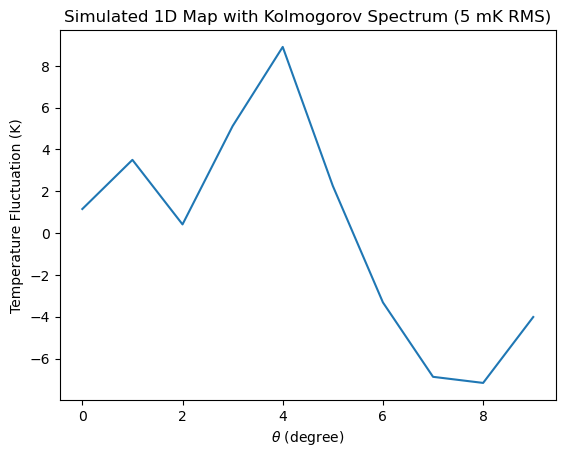

In [22]:
#First do the static case:
# Define map size
target_rms = 5  # Target RMS fluctuation (5 mK)

# Generate wavenumbers
k = np.fft.fftfreq(npix) * npix  # Normalize k values

# Define the Kolmogorov power spectrum P(k) ∝ k^(-11/3)
P_k = np.where(k >= 1.e-3, k**(-11/3), 0)  # Avoid division by zero

# Generate Gaussian random field in Fourier space
rand_re = np.random.randn(npix)  # Real part
rand_im = np.random.randn(npix)  # Imaginary part
fourier_field = (rand_re + 1j * rand_im) * np.sqrt(P_k)

# Transform back to real space
simulated_map = np.fft.ifft(fourier_field).real  # Take only real part

# Normalize to 5 mK RMS
simulated_map -= np.mean(simulated_map)  # Zero mean
simulated_map *= target_rms / np.std(simulated_map)  # Scale to desired RMS

# Plot the simulated map
plt.plot(simulated_map)
plt.xlabel("$\\theta$ (degree)")
plt.ylabel("Temperature Fluctuation (K)")
plt.title("Simulated 1D Map with Kolmogorov Spectrum (5 mK RMS)")

# Print verification
print(f"Final RMS of the simulated map: {np.std(simulated_map):.3f} mK")
plt.savefig('kemission.png')

[0.         0.00133333 0.00266667 0.004      0.00533333 0.00666667
 0.008      0.00933333 0.01066667 0.012     ]


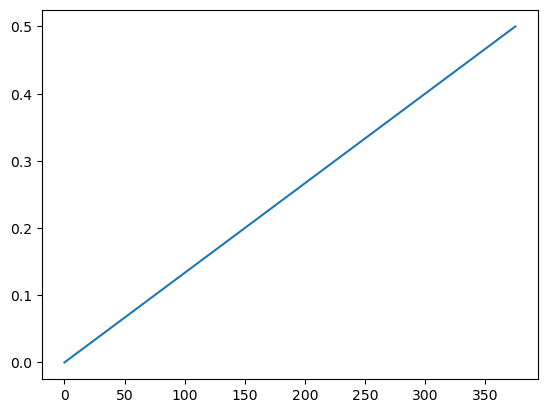

In [23]:
plt.plot(freq)
print(freq[:10])

In [24]:
signal=simulated_map
# Analyze as before
### Pointing Matrix

N_det=3


det_spacing = 1  # Separation between detectors in pixels
sigma = 0.5  # Beam width in pixel units

# Simulated pointing locations for the first detector
location = np.linspace(0, npix, nsamp)  # Example: Detector sweeps across pixels
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

eps = 1e-12  # Small value to prevent division by zero
# Fill the pointing matrix
for d, offset in enumerate(detector_offsets):  # Loop over detectors
    for i, p in enumerate(location):  # Loop over time samples
        index = i + d * nsamp  # New index for multiple detectors
        for j in range(npix):  # Loop over sky pixels
            Pw[index, j] = np.exp(-0.5 * ((p + offset - j) / sigma) ** 2)  # Gaussian weight
        row_sum = np.sum(Pw[index, :])
        if row_sum > 0:  # Only normalize if row sum is nonzero
            Pw[index, :] /= row_sum
        else:
            print(f"Warning: Row {index} has all zeros and cannot be normalized.")
        #Pw[index, :] /= (np.sum(Pw[index, :]) + eps)  # Add small constant


## Noise
# Define frequency-domain power spectrum (inverse covariance)
## So I think it's cleanest to keep everything in units of samples. 
## The knee frequency is roughly 0.03 Hz. The sampling rate is 150 Hz, so in units of the sampling rate, the knee frequency should be
## .03/150=4.5e-4
#SPT noise per pixel is roughly 1 mu K and that comes from beating down detector noise 
# [and atmospheric noise on larger scales] with multiple visits, 
#call it 3000 visits per pixel. That means each 100 second scan has detector noise of order 1 muK X \sqrt{3000} \sim 50 \mu K. 
noise_amp=0.05**2 # mK
inv_ps = 1./noise_amp / (1 + (np.maximum(freq, freq[1] / 2) / 4.5e-4) ** -3.5)

# Initialize the full noise correlation matrix F (block-diagonal)
F = np.zeros((nsamp * N_det, nsamp * N_det))

# Identity matrix for impulse response
I = np.eye(nsamp)



# Construct block-diagonal noise covariance (uncorrelated between detectors)
for d in range(N_det):  # Loop over detectors
    for i in range(nsamp):  # Loop over time samples
        row_idx = d * nsamp + i  # Index in full matrix
        col_start = d * nsamp  # Block placement (only within the same detector)

        # Generate noise correlation for a single detector
        noise_corr = np.fft.irfft(inv_ps * np.fft.rfft(I[i]), n=nsamp)

        # Assign to the block-diagonal part of F
        F[row_idx, col_start:col_start + nsamp] = noise_corr

# Add small identity term to avoid singular matrix issues
F += 1e-10 * np.eye(nsamp * N_det)

# Generate correlated noise realizations
L = np.linalg.cholesky(F)  # Cholesky decomposition

In [25]:
nsim=1
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
data_map_ml=np.zeros((npix,nsim))
N = np.linalg.inv(F)  # Compute true noise covariance
N=noise_amp*N/N[0,0]
F=np.linalg.inv(N)
L_N = np.linalg.cholesky(N)  # Cholesky decomposition of noise covariance
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))

for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L_N @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    #map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml[:,i] = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml[:,i]-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[1],np.mean(bstd))

ML:  0.005859449908705461 0.0
Unweighted:  0.0059598867079837525 0.0 0.0077107970672180455 0.0069737557081926745


(376,) 750 0.5 0.0013333333333333333


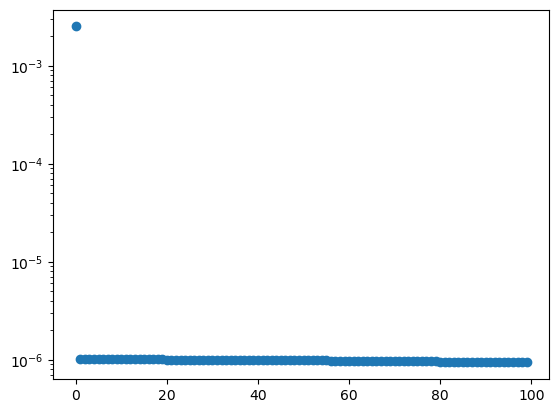

In [26]:
plt.scatter(range(100),N[0,:100])
plt.yscale('log')
print(np.shape(freq),nsamp,freq[-1],freq[1])

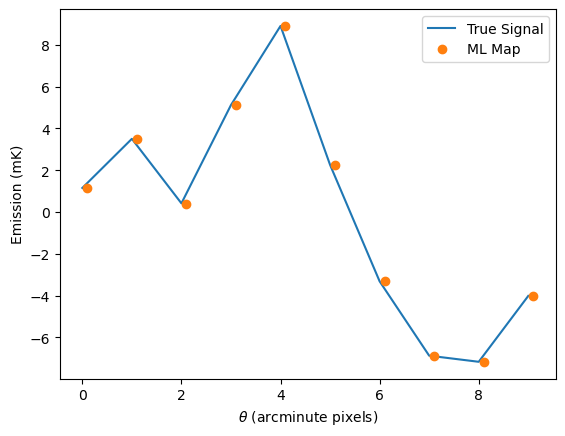

In [27]:
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
#data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map_ml,'o',label='ML Map')
#error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
#plt.errorbar(range(npix),data_map_ml[:,-1],yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('$\\theta$ (arcminute pixels)')
plt.ylabel('Emission (mK)')
plt.legend()

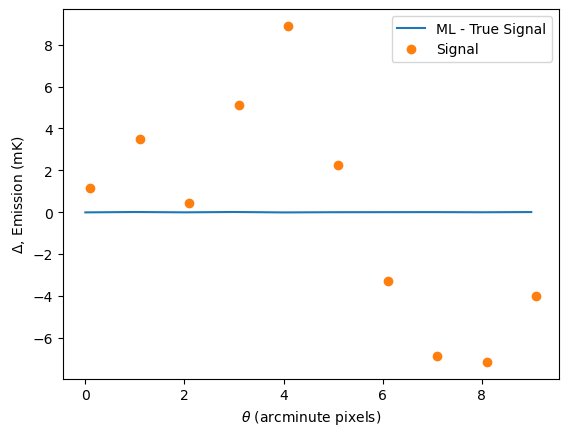

In [28]:
#data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),(data_map_ml[:,0]-signal),label='ML - True Signal')
plt.plot(np.arange(0,npix)+.1,signal,'o',label='Signal')
#error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
#plt.errorbar(range(npix),data_map_ml[:,-1],yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('$\\theta$ (arcminute pixels)')
plt.ylabel('$\\Delta$, Emission (mK)')
plt.legend()

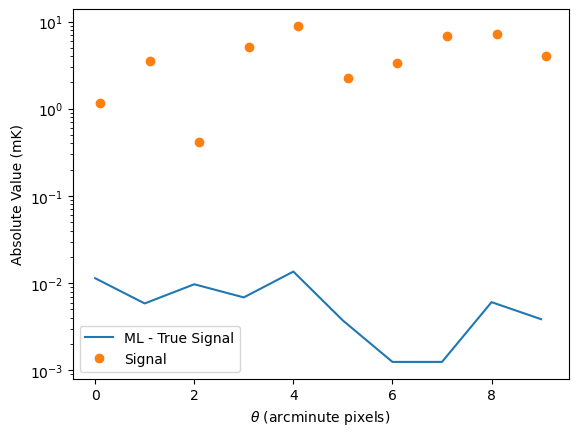

In [30]:
plt.plot(range(npix),np.abs(data_map_ml[:,0]-signal),label='ML - True Signal')
plt.plot(np.arange(0,npix)+.1,np.abs(signal),'o',label='Signal')
#error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
#plt.errorbar(range(npix),data_map_ml[:,-1],yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('$\\theta$ (arcminute pixels)')
plt.ylabel('Absolute Value (mK)')
plt.yscale('log')
plt.legend()
plt.savefig('signoise.png')

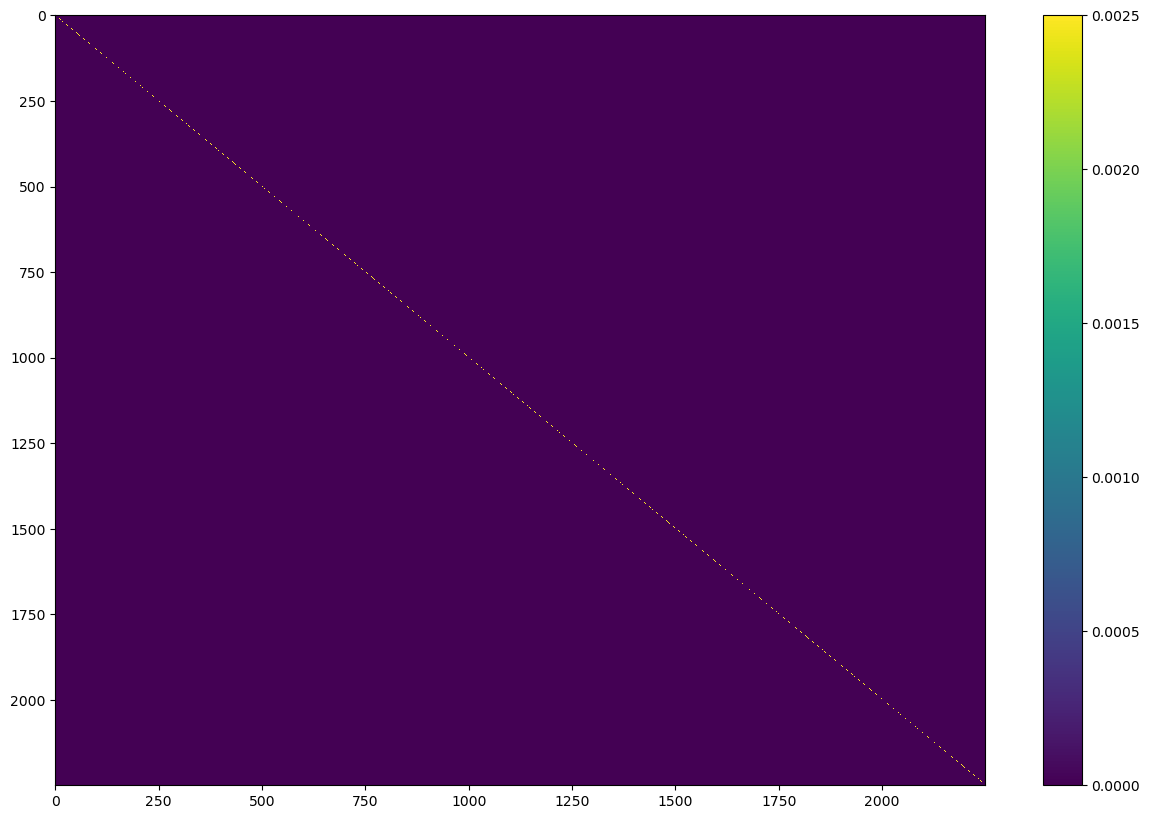

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))  # Width=15, Height=10 (adjust as needed)

# Display the matrix as an image
im = ax.imshow(N, aspect='auto', cmap='viridis', interpolation='nearest')

# Add colorbar
plt.colorbar(im)


In [50]:
## Noise
## Noise
# Define frequency-domain power spectrum (inverse covariance)
freq = np.fft.rfftfreq(nsamp)
#SPT noise per pixel is roughly 1 mu K and that comes from beating down detector noise 
# [and atmospheric noise on larger scales] with multiple visits, 
#call it 3000 visits per pixel. That means each 100 second scan has detector noise of order 1 muK X \sqrt{3000} \sim 50 \mu K. 
noise_amp=0.1**2 # mK
inv_ps = 1./noise_amp / (1 + (np.maximum(freq, freq[1] / 2) / 0.03) ** -3.5)

# Initialize the full noise correlation matrix F (block-diagonal)
F = np.zeros((nsamp * N_det, nsamp * N_det))

# Identity matrix for impulse response
I = np.eye(nsamp)



# Construct block-diagonal noise covariance (uncorrelated between detectors)
for d in range(N_det):  # Loop over detectors
    for i in range(nsamp):  # Loop over time samples
        row_idx = d * nsamp + i  # Index in full matrix
        col_start = d * nsamp  # Block placement (only within the same detector)

        # Generate noise correlation for a single detector
        noise_corr = np.fft.irfft(inv_ps * np.fft.rfft(I[i]), n=nsamp)

        # Assign to the block-diagonal part of F
        F[row_idx, col_start:col_start + nsamp] = noise_corr

# Add small identity term to avoid singular matrix issues
F += 1e-10 * np.eye(nsamp * N_det)


In [51]:
sn=5
signal = sn*np.sin(np.linspace(0, 2 * np.pi, npix)) 
nsim=1
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
data_map_ml=np.zeros((npix,nsim))
N = np.linalg.inv(F)  # Compute true noise covariance
N=noise_amp*N/N[0,0]
F=np.linalg.inv(N)
L_N = np.linalg.cholesky(N)  # Cholesky decomposition of noise covariance
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
print('here')
for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L_N @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    print('here')
#map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml[:,i] = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml[:,i]-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[1],np.mean(bstd))

here
here
ML:  8.22094287917241e-05 0.0
Unweighted:  -0.025897081300557956 0.0 8.309165573423675e-05 0.018055369920392063


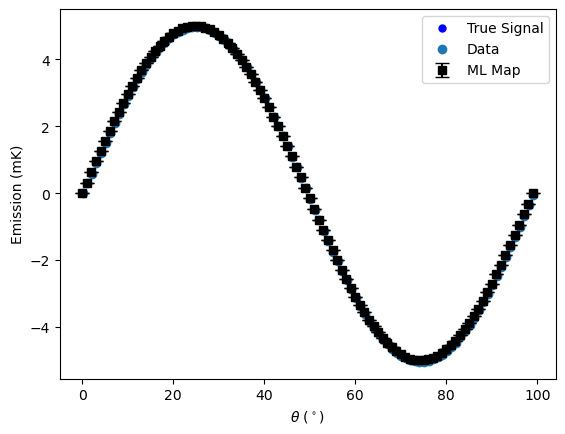

In [53]:
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
#data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,'ob',ms=5,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml[:,-1],yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('$\\theta$ ($^\circ$)')
plt.ylabel('Emission (mK)')
plt.legend()

In [54]:
print(np.sqrt(N[0,0]))
print(error)

0.1
[1.11924696e-04 8.30916557e-05 1.15089363e-04 1.37277959e-04
 1.55965923e-04 1.72300051e-04 1.86898038e-04 2.00139645e-04
 2.12278575e-04 2.23494512e-04 2.33920382e-04 2.43657905e-04
 2.52787049e-04 2.61372087e-04 2.69465626e-04 2.77111392e-04
 2.84346204e-04 2.91201408e-04 2.97703942e-04 3.03877145e-04
 3.09741371e-04 3.15314476e-04 3.20612198e-04 3.25648463e-04
 3.30435628e-04 3.34984687e-04 3.39305434e-04 3.43406599e-04
 3.47295966e-04 3.50980471e-04 3.54466283e-04 3.57758875e-04
 3.60863092e-04 3.63783196e-04 3.66522926e-04 3.69085534e-04
 3.71473830e-04 3.73690219e-04 3.75736736e-04 3.77615080e-04
 3.79326653e-04 3.80872583e-04 3.82253764e-04 3.83470882e-04
 3.84524448e-04 3.85414822e-04 3.86142244e-04 3.86706858e-04
 3.87108729e-04 3.87347865e-04 3.87424228e-04 3.87337746e-04
 3.87088315e-04 3.86675802e-04 3.86100034e-04 3.85360796e-04
 3.84457807e-04 3.83390709e-04 3.82159041e-04 3.80762213e-04
 3.79199478e-04 3.77469903e-04 3.75572339e-04 3.73505379e-04
 3.71267336e-04 3.68

So for this longwength mode that corresponds to $l=3.6$, with detector noise RMS equal to 0.05 mK per sample, each one-degree pixel signal is detected with an error of order 3.e-4 mK = 0.3 $\mu$K.

chatgpt says for SPT, “For any system: σtime sample\=Noise Spectral Density (pA/Hz)Sampling Frequency (Hz)\\sigma\_{\\text{time sample}} = \\frac{\\text{Noise Spectral Density (pA/\\(\\sqrt{\\text{Hz}}\\))}}{\\sqrt{\\text{Sampling Frequency (Hz)}}}σtime sample​\=Sampling Frequency (Hz)​Noise Spectral Density (pA/Hz​)​If you're using a **different sampling frequency**, just plug in the appropriate value.”

For SPT-3G-like numbers, expect the time-domain noise to be about 10× smaller than the frequency-domain noise. “If the **RMS noise per sample** is **1 pA** (as calculated before), the corresponding temperature noise is: $σ_T=\frac{1 pA}{10 pA/mK}=0.1$ mK.\sigma\_T = \\frac{1 \\text{ pA}}{10 \\text{ pA/mK}} = 0.1 \\text{ mK}.σT​\=10 pA/mK1 pA​\=0.1$ mK.”

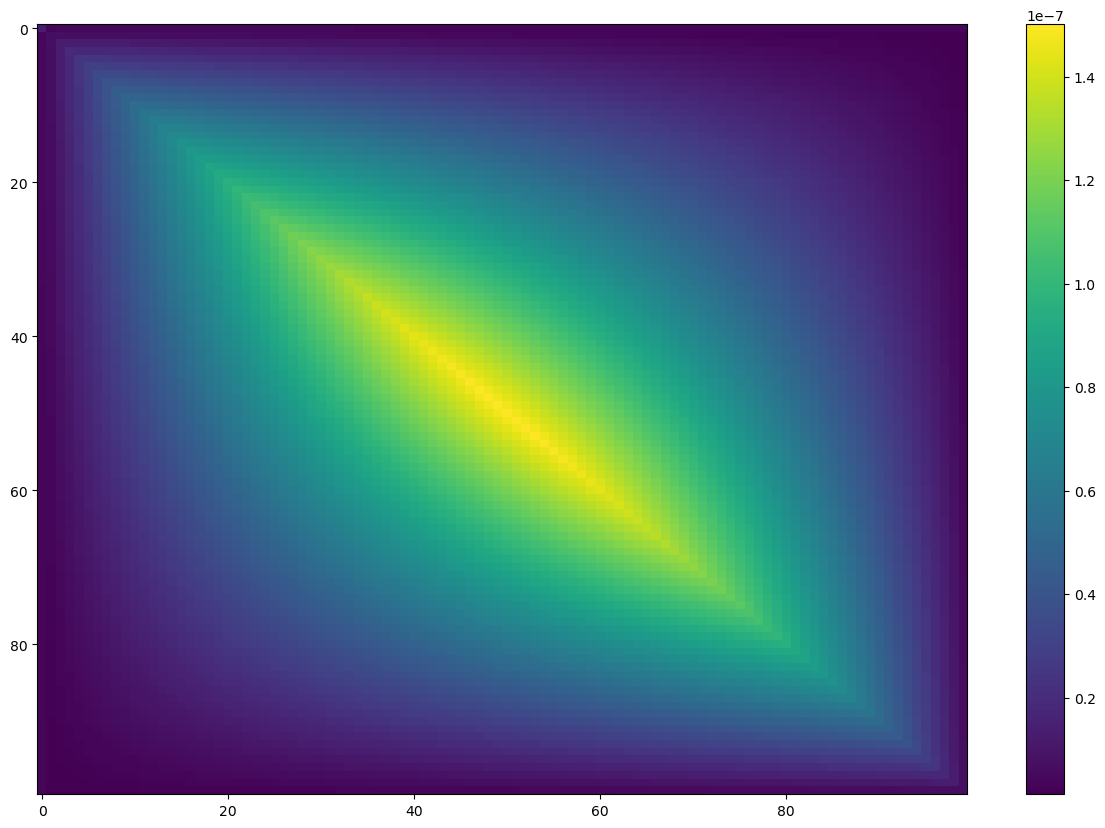

In [55]:
ematrix=np.linalg.inv(Pw.T.dot(F).dot(Pw))
fig, ax = plt.subplots(figsize=(15, 10))  # Width=15, Height=10 (adjust as needed)

# Display the matrix as an image
im = ax.imshow(ematrix, aspect='auto', cmap='viridis', interpolation='nearest')

# Add colorbar
plt.colorbar(im)
